My dad is a [physicist of the old school](https://www.smbc-comics.com/index.php?db=comics&id=2556), and what this means is that he has to tell everyone -- regardless of their field -- that what they're doing is so simple as to not even be worth doing and that anyway physicsists could do it better.
So whenever my job comes up he has to tell the same story about how he once took a problem to a numerical analyst.
This poor bastard ran some code for him on a state-of-the-art computer of the time (a deer skeleton with a KT88 vacuum tube in its asshole) but the solution was total nonsense and didn't even conserve energy.
Then pops realizes he could solve the [Hamilton-Jacobi](https://en.wikipedia.org/wiki/Hamilton%E2%80%93Jacobi_equation) equation for the system exactly.
Numerical analysis is for clowns.

Naturally, every time we have this conversation, I remind him that we figured out all sorts of things since then, like the fact that people who don't own land should be allowed to vote and also symplectic integrators.
In this post I'll talk about the latter.
A symplectic integrator is a scheme for solving Hamilton's equations of motion of classical mechanics in such a way that the map from the state at one time to the state at a later time preserves the canonical symplectic form.
This is a very special property and not every timestepping scheme is symplectic.
For those schemes that are symplectic, the trajectory samples exactly from the flow of a slightly perturbed Hamiltonian, which is a pretty nice result.

## The two-body problem

First, we'll illustrate things on the famous two-body problem, which has the Hamiltonian

$$H = \frac{|p_1|^2}{2m_1} + \frac{|p_2|^2}{2m_2} - \frac{Gm_1m_2}{|x_1 - x_2|}$$

where $x_1$, $x_2$ are the positions of the two bodies, $m_1$, $m_2$ their masses, and $G$ the Newton gravitation constant.
We can simplify this system by instead working in the coordinate system $Q = (m_1x_1 + m_2x_2) / (m_1 + m_2)$, $q = x_2 - x_1$.
The center of mass $Q$ moves with constant speed, reducing the Hamiltonian to

$$H = \frac{|p|^2}{2\mu} - \frac{Gm_1m_2}{|q|}$$

where $\mu = m_1m_2 / (m_1 + m_2)$ is the reduced mass of the system.
We could go on to write $q$ in polar coordinates and do several transformations to derive an exact solution; you can find this in the books by Goldstein or Klepper and Kolenkow.

Instead, we'll take the Hamiltonian above as our starting point, but first we want to make the units work out as nicely as possible.
The gravitational constant $G$ has to have units of length${}^3\cdot$time${}^{-2}\cdot$mass${}^{-1}$ in order for both terms in the Hamiltonian we wrote above to have units of energy.
We'd like for all the lengths and times in the problem to work out to be around 1, which suggests that we measure time in years and length in astronomic units.
The [depository of all knowledge](https://en.wikipedia.org/wiki/Gravitational_constant#Orbital_mechanics) tells me that, in this unit system, the gravitational constant is

$$G \approx 4\pi^2\, \text{AU}^3 \cdot \text{yr}^{-2}\cdot M_\odot^{-1}.$$

The factor of $M_\odot^{-1}$ in the gravitational constant will cancel with the corresponding factor in the Newton force law.
For something like the earth-sun system, where the mass of the sun is much larger than that of the earth, the reduced mass of the system is  about equal to the mass of the earth.
So if we take the earth mass $M_\oplus$ as our basic mass unit, the whole system works out to about

$$H = \frac{|p|^2}{2} - \frac{4\pi^2}{|q|}.$$

Finally, in this unit system we can take the initial position of the earth to be a $(1, 0)$ AU; we know the angular velocity of the earth is about $2\pi$ AU / year, so the initial momentum is $2\pi$ AU / year.
Hamilton's equations of motion are

$$\begin{align}
\dot q & = +\frac{\partial H}{\partial p} = p \\
\dot p & = -\frac{\partial H}{\partial q} = -4\pi^2\frac{q}{|q|^3}.
\end{align}$$

To start, we'll try out the classic explicit and implicit Euler methods first.

In [1]:
import numpy as np
from numpy import pi as π

q_0 = np.array([1.0, 0.0])
p_0 = np.array([0.0, 2 * π])

final_time = 3.0
num_steps = 3000
dt = final_time / num_steps

In [2]:
def gravitational_force(q):
    return -4 * π ** 2 * q / np.sqrt(np.dot(q, q)) ** 3

In [3]:
def explicit_euler(q, p, dt, num_steps, force):
    qs = np.zeros((num_steps + 1,) + q.shape)
    ps = np.zeros((num_steps + 1,) + p.shape)

    qs[0] = q
    ps[0] = p

    for t in range(num_steps):
        qs[t + 1] = qs[t] + dt * ps[t]
        ps[t + 1] = ps[t] + dt * force(qs[t])
        
    return qs, ps

We'll call out to scipy's nonlinear solver for our implementation of the implicit Euler method.
In principle, scipy can solve the resulting nonlinear system of equations solely with the ability to evaluate the forces.
But in order to make this approach as competitive as possible we should also provide the derivative of the forces with respect to the positions, which enables using Newton-type methods.

In [4]:
I = np.eye(2)

def gravitational_force_jacobian(q):
    Q = np.sqrt(np.dot(q, q))
    return -4 * π ** 2 / Q ** 3 * (I - 3 * np.outer(q, q) / Q ** 2)

In [5]:
from scipy.optimize import root

def implicit_euler(q, p, dt, num_steps, force, force_jacobian):
    qs = np.zeros((num_steps + 1,) + q.shape)
    ps = np.zeros((num_steps + 1,) + p.shape)

    qs[0] = q
    ps[0] = p

    def f(q, q_t, p_t):
        return q - q_t - dt * (p_t + dt * force(q))
    
    def J(q, q_t, p_t):
        return I - dt ** 2 * force_jacobian(q)
    
    for t in range(num_steps):
        result = root(f, qs[t, :], jac=J, args=(qs[t], ps[t]))
        qs[t + 1] = result.x
        ps[t + 1] = ps[t] + dt * force(qs[t + 1])
        
    return qs, ps

In [6]:
q_ex, p_ex = explicit_euler(
    q_0, p_0, dt, num_steps, gravitational_force
)

In [7]:
q_im, p_im = implicit_euler(
    q_0, p_0, dt, num_steps, gravitational_force, gravitational_force_jacobian
)

In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_trajectory(q, start_width=1.0, end_width=3.0, **kwargs):
    points = q.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    widths = np.linspace(start_width, end_width, len(points))
    return LineCollection(segments, linewidths=widths, **kwargs)

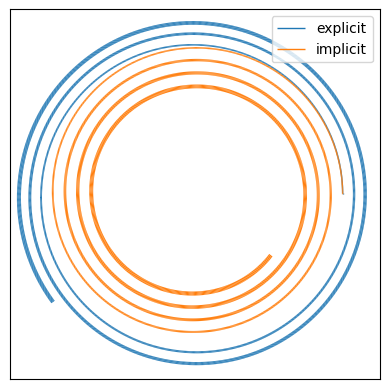

In [9]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim((-1.25, +1.25))
ax.set_ylim((-1.25, +1.25))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.add_collection(plot_trajectory(q_ex, color="tab:blue", label="explicit"))
ax.add_collection(plot_trajectory(q_im, color="tab:orange", label="implicit"))
ax.legend(loc="upper right");

The explicit Euler method spirals out from what looks like to be a circular orbit at first, while the implicit Euler method spirals in.
Since the gravitational potential is negative, this means that the explicit Euler scheme is gaining energy, while the implicit Euler scheme is losing energy.

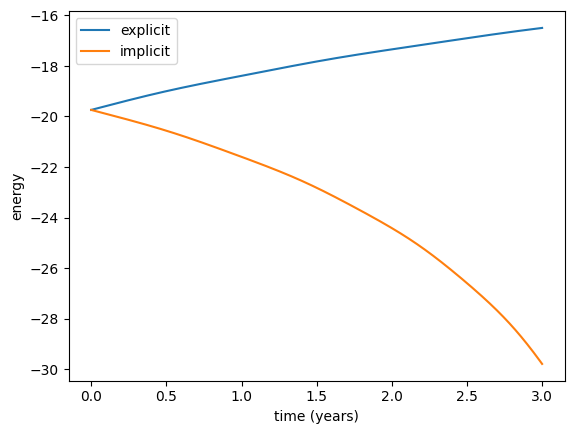

In [10]:
def energies(qs, ps):
    kinetic = 0.5 * np.sum(ps ** 2, axis=1)
    potential = -4 * π ** 2 / np.sqrt(np.sum(qs ** 2, axis=1))
    return kinetic + potential

fig, ax = plt.subplots()
ts = np.linspace(0.0, final_time, num_steps + 1)
ax.plot(ts, energies(q_ex, p_ex), label="explicit")
ax.plot(ts, energies(q_im, p_im), label="implicit")
ax.set_xlabel("time (years)")
ax.set_ylabel("energy")
ax.legend();

If we use a slightly longer timestep, the implicit Euler method will eventually cause the earth and sun to crash into each other in the same short time span of three years.
This prediction does not match observations, much as we might wish.

We could reduce the energy drift to whatever degree we desire by using a shorter timestep or using a more accurate method.
But before we go and look up the coefficients for the usual fourth-order Runge Kutta method, let's instead try a simple variation on the explicit Euler scheme.

In [11]:
from tqdm.notebook import trange
def semi_explicit_euler(q, p, dt, num_steps, force, progressbar=False):
    qs = np.zeros((num_steps + 1,) + q.shape)
    ps = np.zeros((num_steps + 1,) + p.shape)

    qs[0] = q
    ps[0] = p

    iterator = trange(num_steps) if progressbar else range(num_steps)
    for t in iterator:
        qs[t + 1] = qs[t] + dt * ps[t]
        ps[t + 1] = ps[t] + dt * force(qs[t + 1])
        
    return qs, ps

Rather than use the previous values of the system state to pick the next system state, we first updated the position, then used this new value to update the momentum; we used `force(qs[t + 1])` instead of `force(qs[t])`.
This is an implicit scheme in the strictest sense of the word.
The particular structure of the central force problem, however, makes the computations explicit.
In fancy terms we would refer to the Hamiltonian as *separable*.
Let's see how this semi-explicit Euler scheme does.

In [12]:
q_se, p_se = semi_explicit_euler(
    q_0, p_0, dt, num_steps, gravitational_force
)

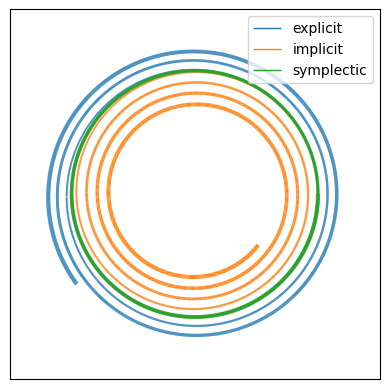

In [13]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim((-1.5, +1.5))
ax.set_ylim((-1.5, +1.5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.add_collection(plot_trajectory(q_ex, color="tab:blue", label="explicit"))
ax.add_collection(plot_trajectory(q_im, color="tab:orange", label="implicit"))
ax.add_collection(plot_trajectory(q_se, color="tab:green", label="symplectic"))
ax.legend(loc="upper right");

The orbit of the semi-explicit or *symplectic* method shown in green seems to be roughly closed, which is pretty good.
The most stunning feature is that the energy drift, while non-zero, is bounded and oscillatory.
The amplitude of the drift is smaller than the energy itself by a factor of about one in 10,000.

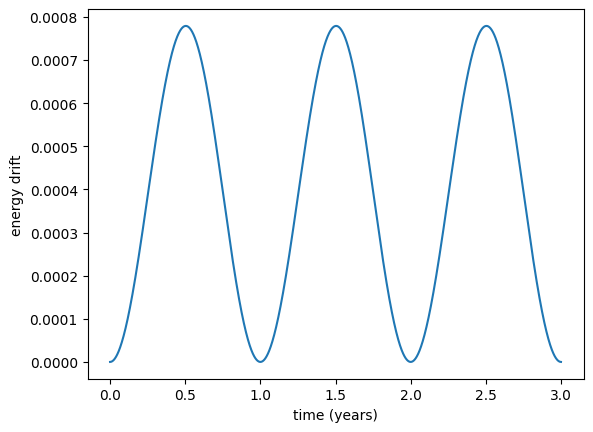

In [14]:
fig, ax = plt.subplots()
Hs = energies(q_se, p_se)
ax.plot(ts, Hs - Hs[0], label="semi-explicit")
ax.set_xlabel("time (years)")
ax.set_ylabel("energy drift");

Just for kicks, let's try again on an elliptical orbit with some more eccentricity than what we tried here, and on the same circular orbit, for a much longer time window.

In [15]:
final_time = 3e2
num_steps = int(3e4)
dt = final_time / num_steps

q_0 = np.array([1.0, 0.0])
p_0 = np.array([0.0, 2 * π])
q_se, p_se = semi_explicit_euler(q_0, p_0, dt, num_steps, gravitational_force)

ϵ = 0.1
q_0 = np.array([1.0 + ϵ, 0.0])
p_0 = np.array([0.0, 2 * π])
q_el, p_el = semi_explicit_euler(q_0, p_0, dt, num_steps, gravitational_force)

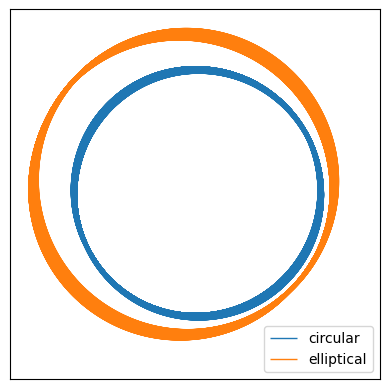

In [16]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim((-1.5, +1.5))
ax.set_ylim((-1.5, +1.5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.add_collection(plot_trajectory(q_se, color="tab:blue", label="circular"))
ax.add_collection(plot_trajectory(q_el, color="tab:orange", label="elliptical"))
ax.legend(loc="lower right");

The orbits don't exactly trace out circles or ellipses -- the orbits *precess* a bit.
Nonetheless, they still remain roughly closed and have bounded energy drift.
For less work than the implicit Euler scheme, we got a vastly superior solution.
**Why is the semi-explicit Euler method so much better than the explicit or implicit Euler method?**

### Symplectic integrators

Arguably the most important property of Hamiltonian systems is that the energy is conserved, as well as other quantities such as linear and angular momentum.
The explicit and implicit Euler methods are convergent, and so their trajectories reproduce those of the Hamiltonian system for any finite time horizon as the number of steps is increased.
These guarantees don't tell us anything about how the discretized trajectories behave using a fixed time step and very long horizons, and they don't tell us anything about the energy conservation properties either.
The wonderful property about semi-explicit Euler is that **the map from the state of the system at one timestep to the next samples directly from the flow of a slightly perturbed Hamiltonian.**

Let's try to unpack that statement a bit more.
A fancy way of writing Hamilton's equations of motion is that, for any observable function $f$ of the total state $z = (q, p)$ of the system,

$$\frac{\partial f}{\partial t} = \{f, H\}$$

where $\{\cdot, \cdot\}$ denotes the [*Poisson bracket*](https://en.wikipedia.org/wiki/Poisson_bracket).
For the simple systems described here, the Poisson bracket of two functions $f$ and $g$ is

$$\{f, g\} = \sum_i\left(\frac{\partial f}{\partial q_i}\frac{\partial g}{\partial p_i} - \frac{\partial f}{\partial p_i}\frac{\partial g}{\partial q_i}\right).$$

We recover the usual Hamilton equations of motion by substituting the positions and momenta themselves for $f$.
In general, the Poisson bracket can be any bilinear form that's antisymmetric and satisfies the Leibniz and Jacobi identities.
In a later demo, I'll look at rotational kinematics, where the configuration space is no longer flat Euclidean space but the Lie group SO(3).
The Poisson bracket is rightfully viewed as a 2-form in this setting.
Leaving this complications aside for the moment, the evolution equation in terms of brackets is especially nice in that it allows us to easily characterize the conserved quantities: any function $f$ such that $\{f, H\} = 0$.
In particular, due to the antisymmetry of the bracket, the Hamiltonian $H$ itself is always conserved.

Solving Hamilton's equations of motion forward in time gives a map $\Phi_t$ from the initial to the final state.
The nice part about this solution map is that it obeys the semi-group property: $\Phi_s\circ\Phi_t = \Phi_{s + t}$.
In the same way that we can think of a matrix $A$ generating the solution map $e^{tA}$ of the linear ODE $\dot z = Az$, we can also think of the solution map for Hamiltonian systems as being generated by the Poisson bracket with the Hamiltonian:

$$\Phi_t = \exp\left(t\{\cdot, H\}\right)$$

where $\exp$ denotes the exponential map.
This isn't a rigorous argument and to really make that clear I'd have to talk about diffeomorphism groups of manifolds.
Just believe me and read Jerrold Marsden's books if you don't.

Now comes the interesting part.
Suppose we want to solve the linear ODE

$$\dot z = (A + B)z.$$

We'd like to find a way to break down solving this problem into separately solving ODEs defined by $A$ and $B$.
It isn't possible to split the problem exactly because, for matrices, $\exp\left(t(A + B)\right)$ is not equal to $\exp(tA)\exp(tB)$ unless $A$ and $B$ commute.
But, for small values of $\delta t$, we can express the discrepancy in terms of the commutate $[A, B] = AB - BA$ of the matrices:

$$\exp(\delta t\cdot A)\exp(\delta t\cdot B) = \exp\left(\delta t(A + B) + \frac{\delta t^2}{2}[A, B] + \ldots\right)$$

where the ellipses denote terms of higher order in $\delta t$.
Exactly what goes in the higher-order terms is the content of the [Baker-Campbell-Hausdorff](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula#Zassenhaus_formula) (BCH) formula.
This reasoning is what leads to splitting methods for all kinds of different PDEs.
For example, you can show that splitting the solution of an advection-diffusion equation into an explicit step for the advective part and an implicit step for the diffusive part works with an error of order $\mathscr{O}(\delta t)$ using the BCH formula.

The clever part about the analysis of symplectic methods is that we can play a similar trick for Hamiltonian problems (if we're willing to wave our hands a bit).
Suppose that a Hamiltonian $H$ can be written as

$$H = H_1 + H_2$$

where exactly solving for the flow of each Hamiltonian $H_1$, $H_2$ is easy.
The most obvious splitting is into kinetic and potential energies $K$ and $U$.
Integrating the Hamiltonian $K(p)$ is easy because the momenta don't change all -- the particles continue in linear motion according to what their starting momenta were.
Integrating the Hamiltonian $U(q)$ is also easy because, while the momenta will change according to the particles' initial positions, those positions also don't change.
To write it down explicitly,

$$\Phi^K_t\left(\begin{matrix}q \\ p\end{matrix}\right) = \left(\begin{matrix}q + t\frac{\partial K}{\partial p} \\ p\end{matrix}\right)$$

and

$$\Phi^U_t\left(\begin{matrix}q \\ p\end{matrix}\right) = \left(\begin{matrix}q \\ p - t\frac{\partial U}{\partial q}\end{matrix}\right)$$

Each of these Hamiltonian systems by itself is sort of silly, but the composition of maps $\Phi^U_{\delta t}\circ \Phi^K_{\delta t}$ gives an $\mathscr{O}(\delta t$)-accurate approximation to $\Phi^{K + U}_{\delta t}$ by the BCH formula.
Now if we keep up the analogy and pretend like we can apply the BCH formula to Hamiltonian flows exactly, we'd formally write that

$$\exp\left(\delta t\{\cdot, H_1\}\right)\exp\left(\delta t\{\cdot, H_2\}\right) = \exp\left(\delta t\{\cdot, H_1 + H_2\} + \frac{\delta t^2}{2}\left\{\cdot, \{H_1, H_2\}\right\} + \ldots \right).$$

In other words, it's not just that using the splitting scheme above is giving us a $\mathscr{O}(\delta t)$-accurate approximation to the solution $q(t), p(t)$, it's that **the approximate solution is sampled exactly from integrating the flow of the perturbed Hamiltonian**

$$H' = H + \frac{\delta t}{2}\{H_1, H_2\} + \mathscr{O}(\delta t^2).$$

All of the things that are true of Hamiltonian systems generally are then true of our numerical approximations.
For example, they still preserve volume in phase space ([Liouville's theorem](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian))); have no stable or unstable equilibrium points, only saddles and centers; and typically have roughly bounded trajectories.

Using the BCH formula to compute the perturbed Hamiltonian helps us design schemes of even higher order.
For example, the scheme that we're using throughout in this post is obtained by taking a full step of the momentum solve followed by a full step of the position solve.
We could eliminate the first-order term in the expansion by taking a half-step of momentum, a full step of position, followed by a half-step of momentum again:

$$\Psi = \Phi^K_{\delta t / 2}\Phi^U_{\delta t}\Phi^K_{\delta t / 2},$$

i.e. a symmetric splitting.
This gives a perturbed Hamiltonian that's accurate to $\delta t^2$ instead:

$$H' = H + \frac{\delta t^2}{24}\left(2\{U, \{U, K\}\} - \{K, \{K, U\}\}\right) + \mathscr{O}(\delta t^4)$$

This scheme is substantially more accurate and also shares a [reversibility](https://en.wikipedia.org/wiki/Time_reversibility) property with the true problem.

Making all of this analysis really rigorous requires a bit of Lie algebra sorcery that I can't claim to understand at any deep level.
But for our purposes it's sufficient to know that symplectic methods like semi-explicit Euler sample exactly from some perturbed Hamiltonian, which is likely to have bounded level surfaces in phase space if the original Hamiltonian did.
This fact gives us stability guarantees that are hard to come by any other way.

### Molecular dynamics

The two-body gravitational problem is all well and good, but now let's try it for a more interesting and complex example: the motion of atoms.
One of the simplest models for interatomic interactions is the [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) (LJ) potential, which has the form

$$U = \epsilon\left(\left(\frac{R}{r}\right)^{12} - 2\left(\frac{R}{r}\right)^6\right).$$

The potential is repulsive at distances less than $R$, attractive at distances between $R$ and $2R$, and pretty much zero at distances appreciably greater than $2R$, with a well depth of $\epsilon$.
The LJ potential is spherically symmetric, so it's not a good model for polyatomic molecules like water that have a non-trivial dipole moment, but it's thought to be a pretty approximation for noble gases like argon.
We'll work in a geometrized unit system where $\epsilon = 1$ and $R = 1$.
The code below calculates the potential and forces for a system of several Lennard-Jones particles.

In [17]:
ϵ = 1.0
R = 1.0

def lennard_jones_potential(q):
    U = 0.0
    n = len(q)
    for i in range(n):
        for j in range(i + 1, n):
            z = q[i] - q[j]
            ρ = np.sqrt(np.dot(z, z)) / R
            U += ϵ / ρ ** 6 * (1 / ρ ** 6 - 2)

    return U

def lennard_jones_force(q):
    fs = np.zeros_like(q)
    n = len(q)
    for i in range(n):
        for j in range(i + 1, n):
            z = q[i] - q[j]
            ρ = np.sqrt(np.dot(z, z)) / R
            f = -12 * ϵ / R ** 2 / ρ ** 8 * (1 - 1 / ρ ** 6) * z
            fs[i] += f
            fs[j] -= f

    return fs

This code runs in $\mathscr{O}(n^2)$ for a system of $n$ particles, but the Lennard-Jones interaction is almost completely negligible for distances greater than $3R$.
There are [approximation schemes](https://en.wikipedia.org/wiki/Barnes%E2%80%93Hut_simulation) that use spatial data structures like [quadtrees](https://en.wikipedia.org/wiki/Quadtree) to index the positions of all the particles and lump the effects of long-range forces.
These schemes reduce the overall computational burden to $\mathscr{O}(n\cdot\log n)$ and are a virtual requirement to running large-scale simulations.

For the initial setup, we'll look at a square lattice of atoms separated by a distance $R$.
We'll start out with zero initial velocity.
If you were to imagine an infinite or periodic lattice of Lennard-Jones atoms, a cubic lattice should be stable.
The points immediately to the north, south, east, and west on the grid are exactly at the equilibrium distance, while the forces between an atom and its neighbors to the northwest and southeast should cancel.
For this simulation, we won't include any periodicity, so it's an interesting question to see if the cubic lattice structure remains even in the presence of *edge effects*.

In [18]:
num_rows, num_cols = 10, 10
num_particles = num_rows * num_cols

q = np.zeros((num_particles, 2))
for i in range(num_rows):
    for j in range(num_cols):
        q[num_cols * i + j] = (R * i, R * j)
        
p = np.zeros((num_particles, 2))

I've added a progress bar to the simulation so I can see how fast it runs.
Each iteration usually takes about the same time, so after about 10 or so you can tell whether you should plan to wait through the next cup of coffee or until next morning.

In [19]:
dt = 1e-2
num_steps = 2000

qs, ps = semi_explicit_euler(
    q, p, dt, num_steps, force=lennard_jones_force, progressbar=True
)

  0%|          | 0/2000 [00:00<?, ?it/s]

And now for some pretty animations.

In [20]:
%%capture
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim((qs[:, :, 0].min(), qs[:, :, 0].max()))
ax.set_ylim((qs[:, :, 1].min(), qs[:, :, 1].max()))
ax.set_aspect("equal")
points = ax.scatter(qs[0, :, 0], qs[0, :, 1], animated=True)

def update(timestep):
    points.set_offsets(qs[timestep, :, :])

num_steps = len(qs)
fps = 60
animation = FuncAnimation(fig, update, num_steps, interval=1e3 / fps)

In [21]:
from IPython.display import HTML
HTML(animation.to_html5_video())

The cubic lattice is unstable -- the particles eventually rearrange into a hexagonal lattice.
We can also see this if we plot the potential energy as a function of time.
Around halfway into the simulation, the average potential energy suddenly drops by about $\epsilon / 5$.

In [22]:
ts = np.linspace(0, num_steps * dt, num_steps)
Us = np.array([lennard_jones_potential(q) for q in qs]) / num_particles

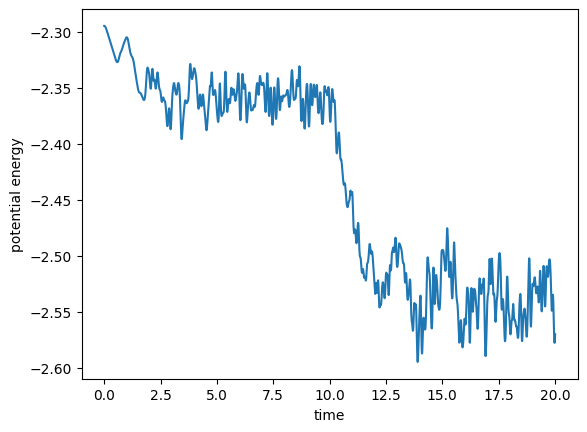

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel("time")
ax.set_ylabel("potential energy")
ax.plot(ts, Us);

By way of a posteriori sanity checking, we can see that the total energy wasn't conserved exactly, but the deviations are bounded and the amplitude is much smaller than the characteristic energy scale $\epsilon$ of the problem.

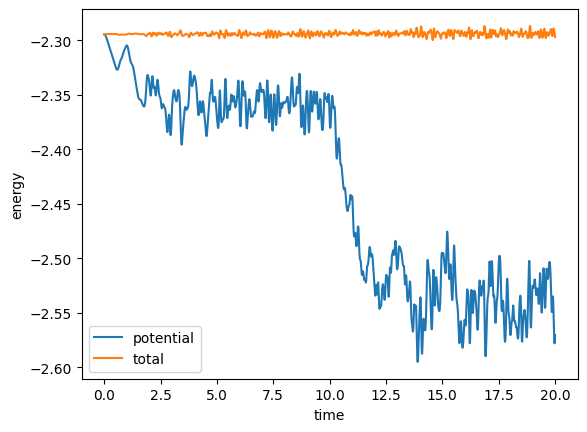

In [24]:
Ks = 0.5 * np.sum(ps ** 2, axis=(1, 2)) / num_particles
Hs = Us + Ks

fig, ax = plt.subplots()
ax.set_xlabel("time")
ax.set_ylabel("energy")
ax.plot(ts, Us, label="potential")
ax.plot(ts, Hs, label="total")
ax.legend();

### Conclusion

An introductory class in numerical ODE will show you how to construct convergent discretization schemes.
Many real problems, however, have special structure that a general ODE scheme may or may not preserve.
Hamiltonian systems are particularly rich in structure -- energy and phase space volume conservation, reversibility.
Some very special discretization schemes preserve this structure.
In this post, we focused only on the very basic symplectic Euler scheme and hinted at the similar but more accurate Störmer-Verlet scheme.
Another simple symplectic method is the implicit midpoint rule

$$\frac{z_{n + 1} - z_n}{\delta t} = f\left(\frac{z_n + z_{n + 1}}{2}\right).$$

There are of course higher-order symplectic schemes, for example Lobatto-type Runge Kutta methods.

We showed a simulation of several particles interacting via the Lennard-Jones potential, which is spherically symmetric.
Things get much more complicated when there are rotational degrees of freedom.
The rotational degrees of freedom live not in flat Euclidean space but on the Lie group SO(3), and the angular momenta in the Lie algebra $\mathfrak{so}(3)$.
More generally, there are specialized methods for problems with constraints, such as being a rotation matrix, or being confined to a surface.

If you want to learn more, my favorite references are [Geometric Numerical Integration](https://doi.org/10.1007/3-540-30666-8) by Hairer, Lubich, and Wanner and [Simulating Hamiltonian Dynamics](https://doi.org/10.1017/CBO9780511614118) by Leimkuhler and Reich.